# QSAR Oral Toxicity Dataset - Lab 5

In [23]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, validation_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2, mutual_info_classif, f_classif, f_regression
from sklearn.naive_bayes import *
import sklearn.metrics as metrics
from numpy import percentile
from subprocess import call
import statsmodels.api as sm
import seaborn as sns

In [2]:
data: pd.DataFrame = pd.read_csv('datasets/qsar_oral_toxicity_v2.csv')
target = 'IS_TOXIC'
original_data = data.copy()

y: np.ndarray = data.pop(target).values
X: np.ndarray = data.values
labels = pd.unique(y)

## **Feature Selection**

## Filter-based methods

### Chi-Squared

Pearson’s chi-squared statistical hypothesis test is an example of a test for independence between categorical variables.

Feature 0: 14.861269
Feature 1: 5.549164
Feature 2: 15.105325
Feature 3: 30.186018
Feature 4: 0.562967
Feature 5: 6.170343
Feature 6: 1.399669
Feature 7: 20.967530
Feature 8: 0.135094
Feature 9: 0.002787


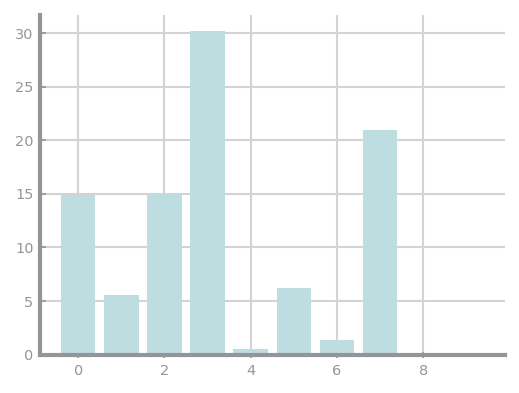

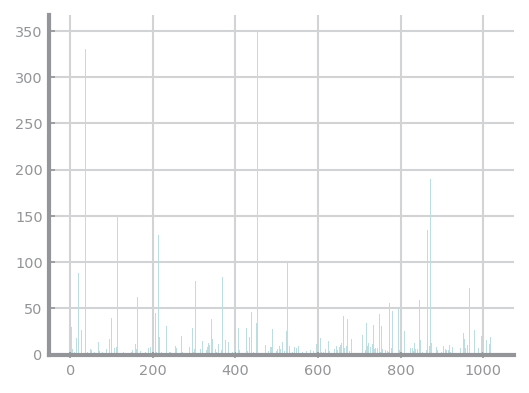

In [3]:
def select_features_chi2(X_train, y_train, X_test):
	fs = SelectKBest(score_func=chi2, k='all')
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)
X_train_fs, X_test_fs, fs = select_features_chi2(trnX, trnY, tstX)

for i in range(10):
	print('Feature %d: %f' % (i, fs.scores_[i]))  # Scores for the features

plt.bar([i for i in range(10)], fs.scores_[:10])
plt.show()

plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

### Mutual Information

Mutual information is the application of information gain to feature selection, it is calculated between two variables and measures the reduction in uncertainty for one variable given a known value of the other variable.

Feature 0: 0.000323
Feature 1: 0.000418
Feature 2: 0.000605
Feature 3: 0.000000
Feature 4: 0.001023
Feature 5: 0.003275
Feature 6: 0.005616
Feature 7: 0.004812
Feature 8: 0.000000
Feature 9: 0.001672


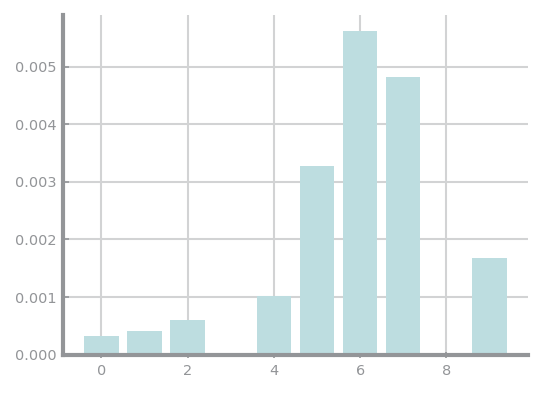

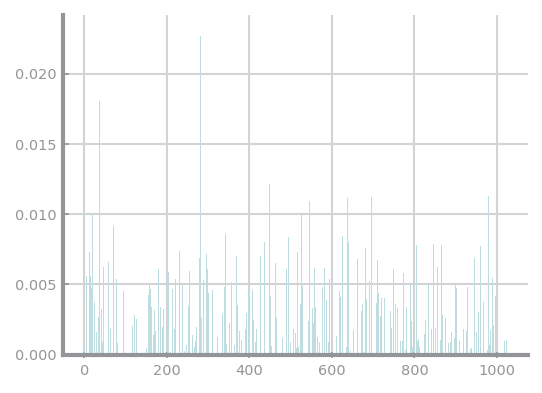

In [4]:
def select_features_mi(X_train, y_train, X_test):
	fs = SelectKBest(score_func=mutual_info_classif, k='all')
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

X_train_fs, X_test_fs, fs = select_features_mi(trnX, trnY, tstX)

for i in range(10):
	print('Feature %d: %f' % (i, fs.scores_[i]))  # Scores for the features

plt.bar([i for i in range(10)], fs.scores_[:10])
plt.show()

plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

### Pearson's Correlation

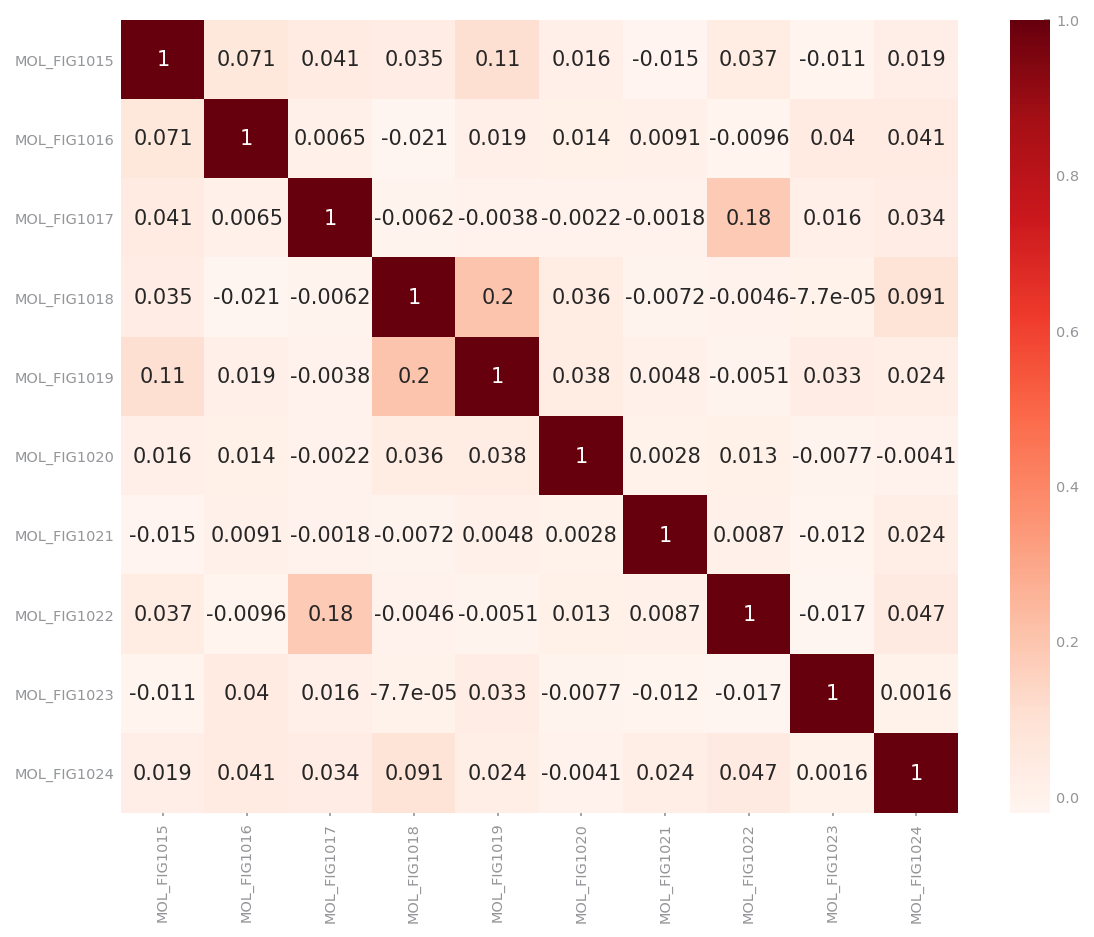

In [5]:
plt.figure(figsize=(9,7))
data_corr = data.copy()
for i in range(1,1015):
    data_corr = data_corr.drop('MOL_FIG'+ str(i), 1)
sns.heatmap(data_corr.corr(), annot=True, cmap=plt.cm.Reds)
plt.show()

The correlation coefficient has values between -1 to 1
* A value closer to 0 implies weaker correlation (exact 0 implying no correlation)
* A value closer to 1 implies stronger positive correlation
* A value closer to -1 implies stronger negative correlation

## **Wrapper-based methods**

### Backward Elimination

The model receives all possible features at first. We check the performance of the model and then iteratively remove the worst performing features one by one till the overall performance of the model comes in acceptable range.

In [6]:
def backward_elimination(X):
    cols = list(X.columns)
    pmax = 1
    while (len(cols)>0):
        p = []
        X_1 = X[cols]
        X_1 = sm.add_constant(X_1)
        model = sm.OLS(y, X_1).fit()  # Ordinary Least Squares
        p = pd.Series(model.pvalues.values[1:], index = cols)      
        pmax = max(p)
        feature_with_p_max = p.idxmax()
        if(pmax>0.05):
            cols.remove(feature_with_p_max)
        else:
            break
    selected_features_BE = cols
    print(selected_features_BE)

### RFE (Recursive Feature Elimination)

The goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. It uses accuracy metric to rank the feature according to their importance.

In [7]:
def rfe(X):
    nof_list=np.arange(1, len(X.columns))   # no of features
    high_score=0
    nof=0           # variable to store the optimum features
    score_list =[]
    for n in range(len(nof_list)):
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
        model = LinearRegression()
        rfe = RFE(model,nof_list[n])
        X_train_rfe = rfe.fit_transform(X_train,y_train)
        X_test_rfe = rfe.transform(X_test)
        model.fit(X_train_rfe,y_train)
        score = model.score(X_test_rfe,y_test)
        score_list.append(score)
        if(score>high_score):
            high_score = score
            nof = nof_list[n]
    print("Optimum number of features: %d" %nof)
    print("Score with %d features: %f" % (nof, high_score))

## Classification models after applying Feature Selection- Comparison

In [8]:
def select_features_numerical(X, y, technique, selection):
    if technique == "pearson":
        scoref = f_regression
    elif technique == "anova":
        scoref = f_classif
    
    if selection == "kbest":
        fs = SelectKBest(score_func=scoref, k=400)
    elif selection == "percentile":
        fs = SelectPercentile(score_func=scoref, percentile=20)
    
    X_selected = fs.fit_transform(X, y)
    #print(X_selected.shape)
    return train_test_split(X_selected, y, train_size=0.7, stratify=y)

In [13]:
def select_features_categorical(X_train, y_train, X_test, technique, selection):
    if technique == "chi2":
        scoref = chi2
    elif technique == "mi":
        scoref = mutual_info_classif
    
    if selection == "kbest":
        fs = SelectKBest(score_func=scoref, k=400)
    elif selection == "percentile":
        fs = SelectPercentile(score_func=scoref, percentile=20)
    
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs

## Naive Bayes

In [19]:
def naive_bayes(trnX, trnY, tstX, tstY, y):
    clf = BernoulliNB()
    clf.fit(trnX, trnY)
    prd_trn = clf.predict(trnX)
    prd_tst = clf.predict(tstX)
    ds.plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)

Confusion Matrix Test
TruePositives:  2014
FalsePositives:  83
TrueNegatives:  139
FalseNegatives:  462


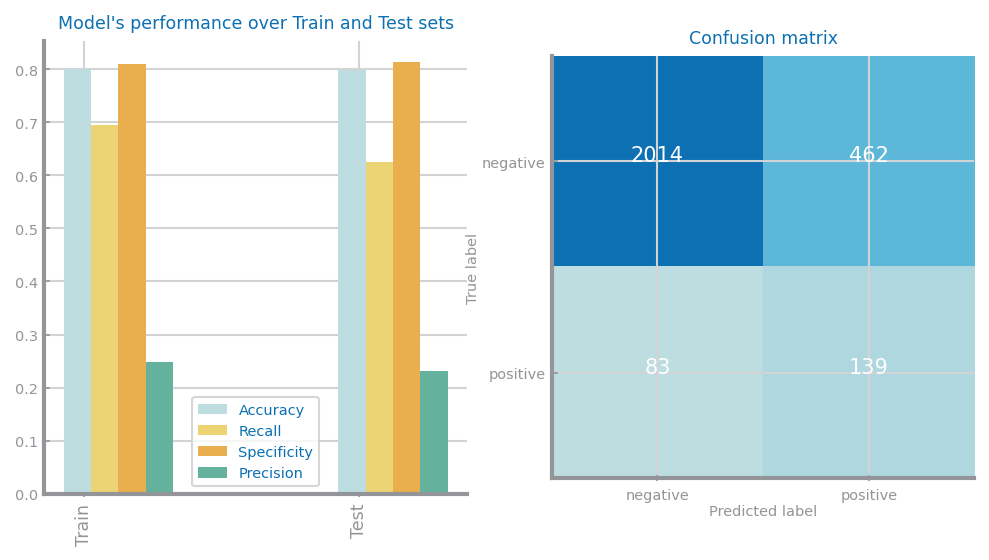

In [20]:
naive_bayes(trnX, trnY, tstX, tstY, y)

### Pearson's Correlation

In [ ]:
X_pearson_kbest, y_pearson_kbest = select_features_numerical(X, y, "pearson", "kbest")
trnX_pearson_kbest, tstX_pearson_kbest, trnY_pearson_kbest, tstY_pearson_kbest = train_test_split(X_pearson_kbest, y_pearson_kbest, train_size=0.7, stratify=y)
naive_bayes(trnX_pearson_kbest, trnY_pearson_kbest, tstX_pearson_kbest, tstY_pearson_kbest, y)

In [ ]:
X_pearson_kbest, y_pearson_kbest = select_features_numerical(X, y, "pearson", "percentile")
trnX_pearson_percentile, tstX_pearson_percentile, trnY_pearson_percentile, tstY_pearson_percentile = train_test_split(X_pearson_kbest, y_pearson_kbest, train_size=0.7, stratify=y)
naive_bayes(trnX_pearson_percentile, trnY_pearson_percentile, tstX_pearson_percentile, tstY_pearson_percentile, y)

### ANOVA

In [5]:
trnX, tstX, trnY, tstY = select_features_numerical(X, y, "anova", "kbest")

In [ ]:
trnX, tstX, trnY, tstY = select_features_numerical(X, y, "anova", "percentile")

### Chi-Squared

Confusion Matrix Test
TruePositives:  2090
FalsePositives:  86
TrueNegatives:  136
FalseNegatives:  386


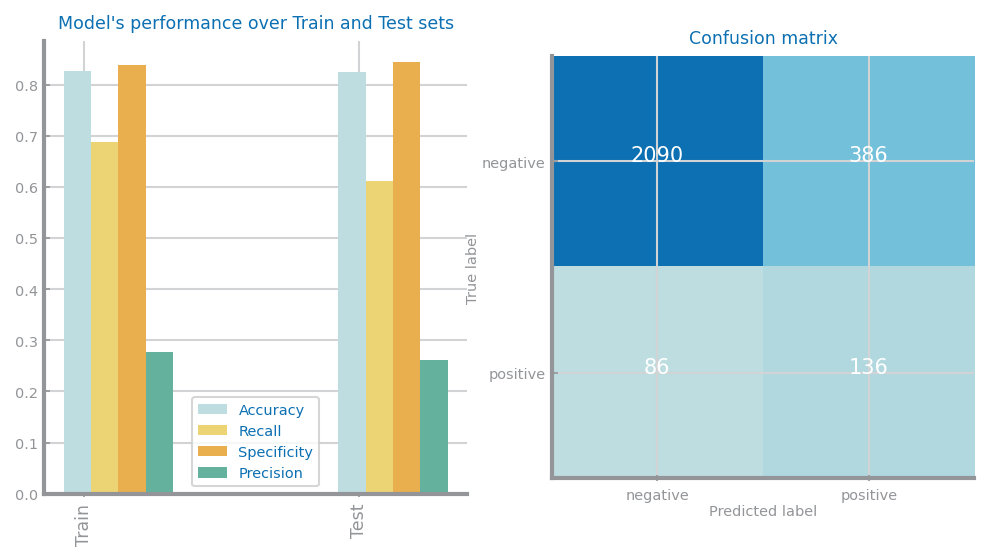

In [21]:
X_train_fs, X_test_fs = select_features_categorical(trnX, trnY, tstX, "chi2", "kbest")
naive_bayes(X_train_fs, trnY, X_test_fs, tstY, y)

Confusion Matrix Test
TruePositives:  2197
FalsePositives:  105
TrueNegatives:  117
FalseNegatives:  279


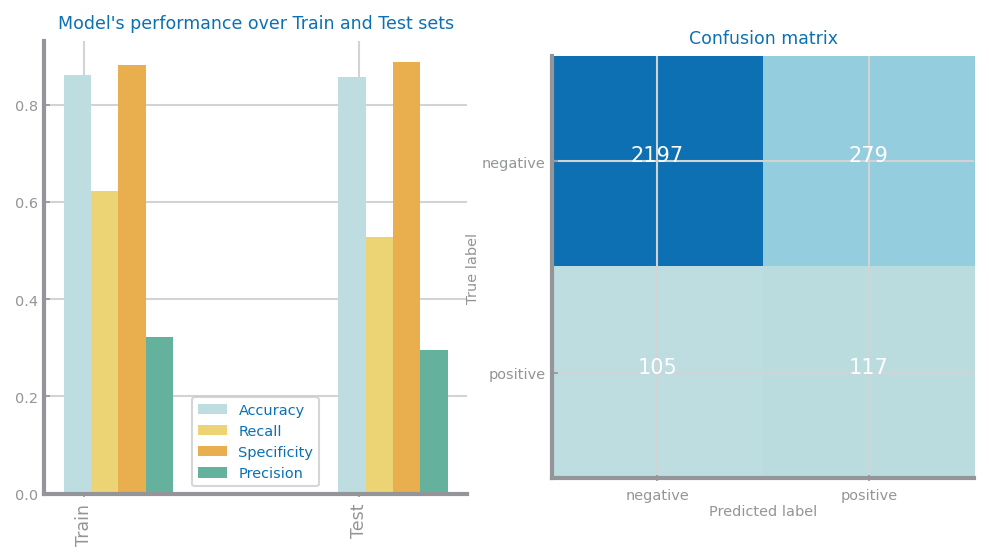

In [24]:
X_train_fs, X_test_fs = select_features_categorical(trnX, trnY, tstX, "chi2", "percentile")
naive_bayes(X_train_fs, trnY, X_test_fs, tstY, y)

### Mutual Information

Confusion Matrix Test
TruePositives:  2204
FalsePositives:  109
TrueNegatives:  113
FalseNegatives:  272


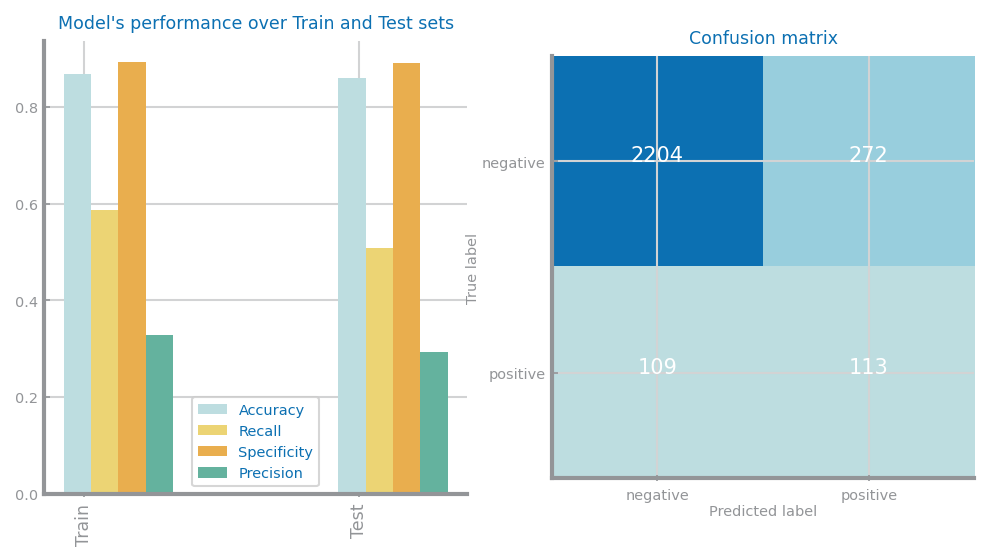

In [26]:
X_train_fs, X_test_fs = select_features_categorical(trnX, trnY, tstX, "mi", "kbest")
naive_bayes(X_train_fs, trnY, X_test_fs, tstY, y)

Confusion Matrix Test
TruePositives:  2271
FalsePositives:  122
TrueNegatives:  100
FalseNegatives:  205


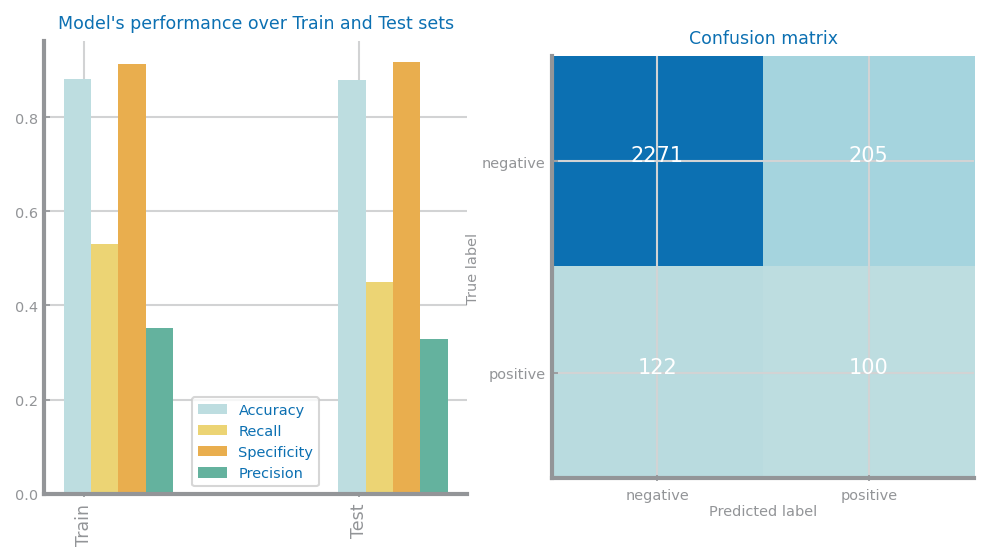

In [27]:
X_train_fs, X_test_fs = select_features_categorical(trnX, trnY, tstX, "mi", "percentile")
naive_bayes(X_train_fs, trnY, X_test_fs, tstY, y)

### Backward Elimination

In [ ]:
backward_elimination(X)

### RFE (Recursive Feature Elimination)

In [ ]:
rfe(X)

## KNN

In [29]:
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsClassifier

def knn_model(trnX, trnY, tstX, tstY):
    nvalue = 7
    dist = 'manhattan'
    values = {}
    best = (0, '')
    last_best = 0
    yvalues = []
    knn = KNeighborsClassifier(n_neighbors=nvalue, metric=dist)
    knn.fit(trnX, trnY)
    prd_trn = knn.predict(trnX)
    prd_tst = knn.predict(tstX)
    ds.plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)

Confusion Matrix Test
TruePositives:  2430
FalsePositives:  150
TrueNegatives:  72
FalseNegatives:  46


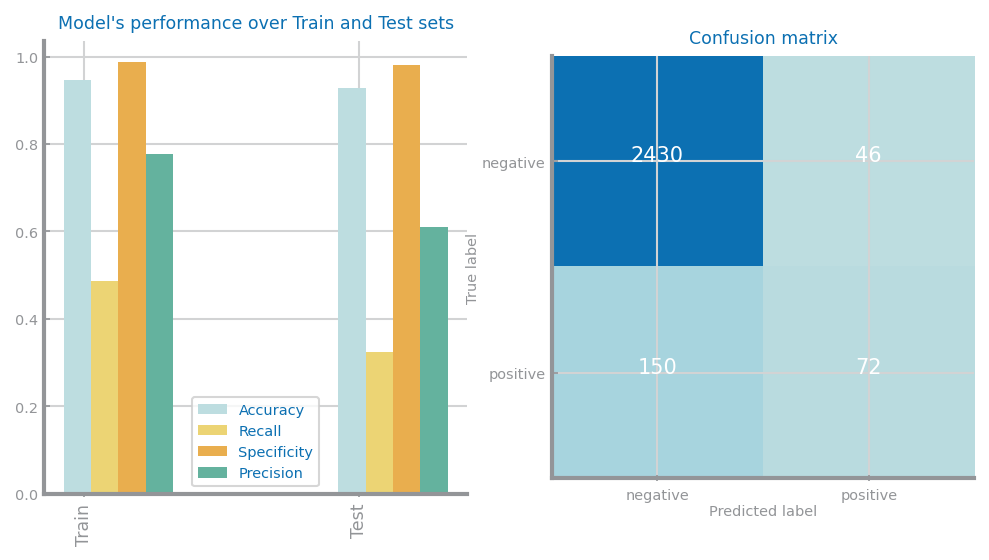

In [30]:
knn_model(trnX, trnY, tstX, tstY)

### Chi-Squared

Confusion Matrix Test
TruePositives:  2431
FalsePositives:  148
TrueNegatives:  74
FalseNegatives:  45


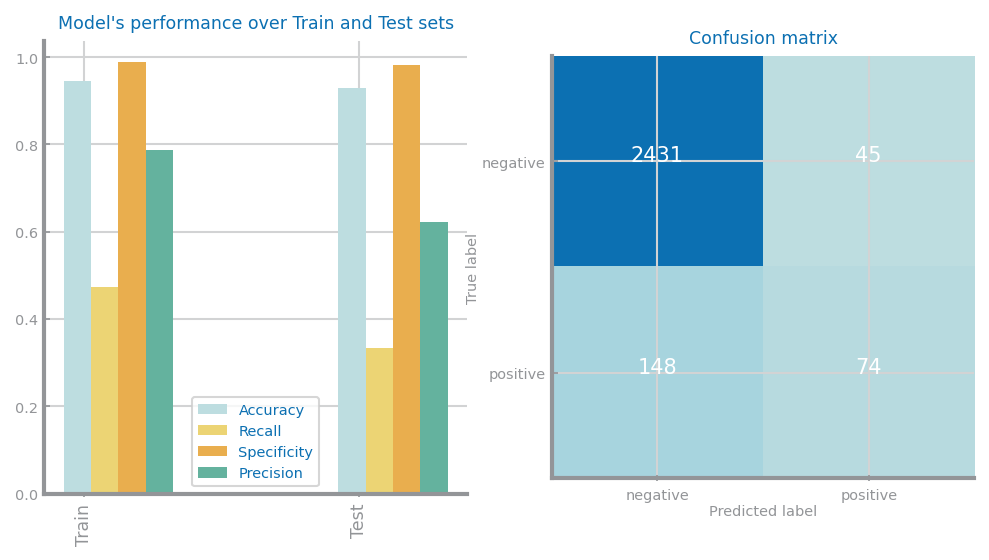

In [32]:
X_train_fs, X_test_fs = select_features_categorical(trnX, trnY, tstX, "chi2", "kbest")
knn_model(X_train_fs, trnY, X_test_fs, tstY)

Confusion Matrix Test
TruePositives:  2436
FalsePositives:  150
TrueNegatives:  72
FalseNegatives:  40


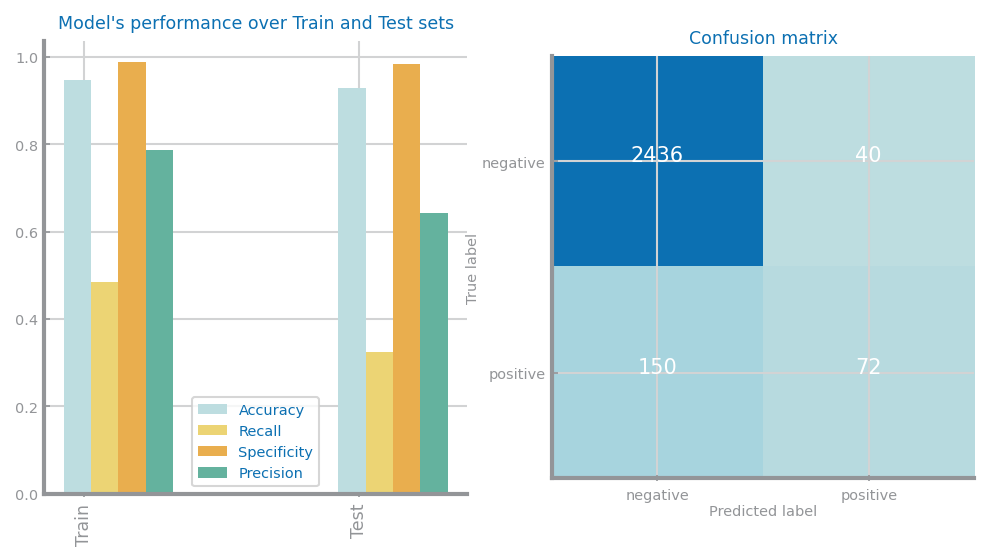

In [34]:
X_train_fs, X_test_fs = select_features_categorical(trnX, trnY, tstX, "chi2", "percentile")
knn_model(X_train_fs, trnY, X_test_fs, tstY)

### Mutual Information

Confusion Matrix Test
TruePositives:  2438
FalsePositives:  144
TrueNegatives:  78
FalseNegatives:  38


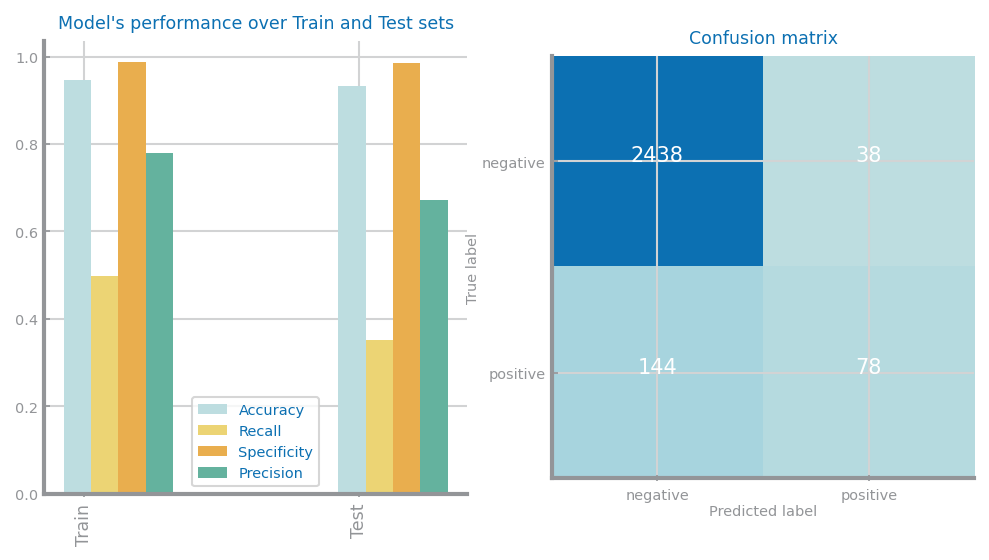

In [35]:
X_train_fs, X_test_fs = select_features_categorical(trnX, trnY, tstX, "mi", "kbest")
knn_model(X_train_fs, trnY, X_test_fs, tstY)

Confusion Matrix Test
TruePositives:  2435
FalsePositives:  152
TrueNegatives:  70
FalseNegatives:  41


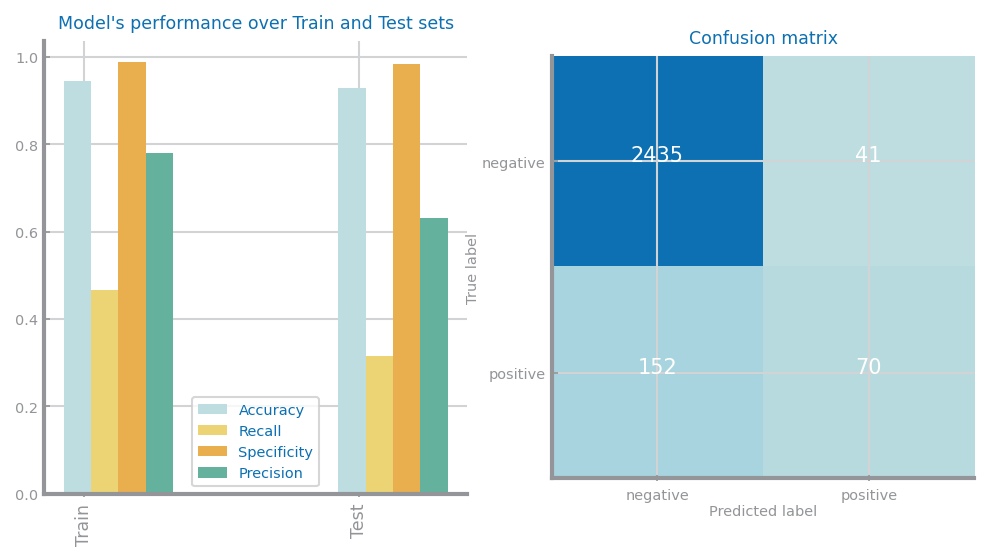

In [36]:
X_train_fs, X_test_fs = select_features_categorical(trnX, trnY, tstX, "mi", "percentile")
knn_model(X_train_fs, trnY, X_test_fs, tstY)

## Decision Trees

In [ ]:
def decision_tree_cross_validation(X, y, num_splits, data, n=5, splitting="StratifiedKFold"):
    if splitting == "StratifiedKFold":
        cv = StratifiedKFold(n_splits=num_splits, random_state=50, shuffle=False)
        cv_split = cv.split(X, y)
    elif splitting == "KFold":
        cv = KFold(n_splits=num_splits, random_state=50, shuffle=False)
        cv_split = cv.split(X)
    elif splitting == "ShuffleSplit":
        cv = ShuffleSplit(n_splits=num_splits, test_size=.25, random_state=0)
        cv_split = cv.split(X)
    else:
        cv = StratifiedShuffleSplit(n_splits=num_splits, test_size=.25, random_state=0)
        cv_split = cv.split(X, y)
        
    for train_index, test_index in cv_split:
        trnX, tstX = X[train_index], X[test_index]
        trnY, tstY = y[train_index], y[test_index]
        best = ('',  0, 0.0)
        last_best = 0
        best_tree = None

        min_impurity_decrease = [0.025, 0.01, 0.005]   #[0.025, 0.01, 0.005, 0.0025, 0.001]
        max_depths = [2, 5, 10]                        #[2, 5, 10, 15, 20, 25]
        criteria = ['entropy', 'gini']
        plt.figure()
        fig, axs = plt.subplots(1, 2, figsize=(16, 4), squeeze=False)
        for k in range(len(criteria)):
            f = criteria[k]
            values = {}
            for d in max_depths:
                yvalues = []
                for imp in min_impurity_decrease:
                    tree = DecisionTreeClassifier(min_samples_leaf=n, max_depth=d, criterion=f, min_impurity_decrease=imp)
                    tree.fit(trnX, trnY)
                    prdY = tree.predict(tstX)
                    yvalues.append(metrics.accuracy_score(tstY, prdY))
                    if yvalues[-1] > last_best:
                        best = (f, d, imp)
                        last_best = yvalues[-1]
                        best_tree = tree

                values[d] = yvalues
            ds.multiple_line_chart(min_impurity_decrease, values, ax=axs[0, k], title='Decision Trees with %s criteria'%f,
                                   xlabel='min_impurity_decrease', ylabel='accuracy', percentage=True)

        plt.show()
        print('Best results achieved with %s criteria, depth=%d and min_impurity_decrease=%1.3f ==> accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

    prd_trn = best_tree.predict(trnX)
    prd_tst = best_tree.predict(tstX)
    ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)

    dot_data = export_graphviz(best_tree, out_file='dtree.dot', filled=True, rounded=True, special_characters=True)
    call(['dot', '-Tpng', 'dtree.dot', '-o', 'dtree.png', '-Gdpi=600']) # Convert to png
    if best_tree.tree_.node_count > 40:
        plt.figure(figsize = (19, 24))
    else:
        plt.figure(figsize = (8, 10))
    plt.imshow(plt.imread('dtree.png'))
    plt.axis('off')
    plt.title("Learned tree for " + splitting + " cross-validator")
    plt.show()

In [ ]:
decision_tree_cross_validation(X, y, num_splits=5, data=data, n=3, splitting="StratifiedKFold")

In [ ]:
decision_tree_cross_validation(X, y, num_splits=5, data=data, n=3, splitting="KFold")

In [ ]:
decision_tree_cross_validation(X, y, num_splits=5, data=data, n=3, splitting="ShuffleSplit")

## No Normalization Needed

## Balancing - Dataset Size

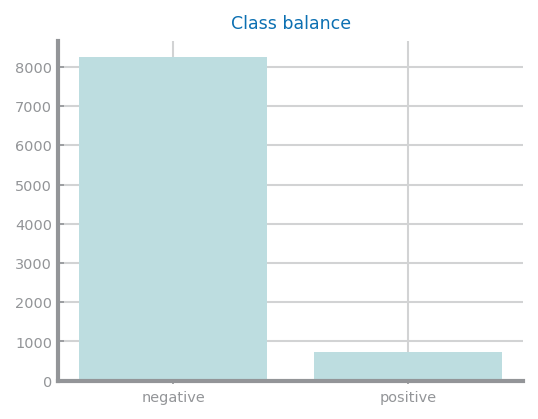

Minority class: 741
Majority class: 8251
Proportion: 0.09 : 1


In [7]:
target_count = original_data[target].value_counts()
plt.figure()
plt.title('Class balance')
plt.bar(target_count.index, target_count.values)
plt.show()

min_class = target_count.idxmin()
ind_min_class = target_count.index.get_loc(min_class)

print('Minority class:', target_count[ind_min_class])
print('Majority class:', target_count[1-ind_min_class])
print('Proportion:', round(target_count[ind_min_class] / target_count[1-ind_min_class], 2), ': 1')

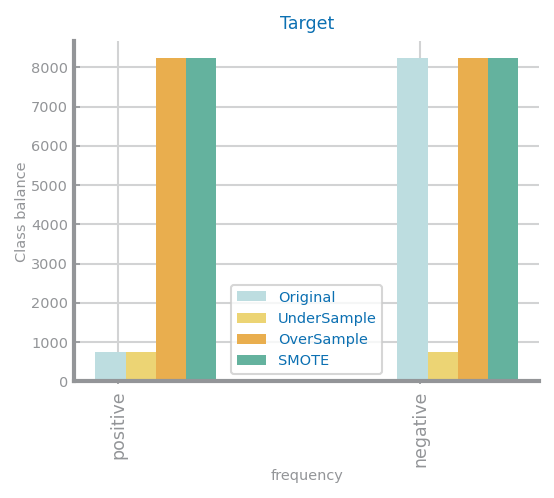

In [8]:
from imblearn.over_sampling import SMOTE

RANDOM_STATE = 42
values = {'Original': [target_count.values[ind_min_class], target_count.values[1-ind_min_class]]}

df_class_min = original_data[original_data[target] == min_class]
df_class_max = original_data[original_data[target] != min_class]

df_under = df_class_max.sample(len(df_class_min))
values['UnderSample'] = [target_count.values[ind_min_class], len(df_under)]
df_over = df_class_min.sample(len(df_class_max), replace=True)
values['OverSample'] = [len(df_over), target_count.values[1-ind_min_class]]
smote = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE)
y = original_data.pop(target).values
X = original_data.values
smote_X, smote_y = smote.fit_sample(X, y)
smote_target_count = pd.Series(smote_y).value_counts()
values['SMOTE'] = [smote_target_count.values[ind_min_class], smote_target_count.values[1-ind_min_class]]

fig = plt.figure()
ds.multiple_bar_chart([target_count.index[ind_min_class], target_count.index[1-ind_min_class]], values,
                      title='Target', xlabel='frequency', ylabel='Class balance')
plt.show()

## Unbalanced Classification

{ 8992 , 8992 }


<Figure size 600x450 with 0 Axes>

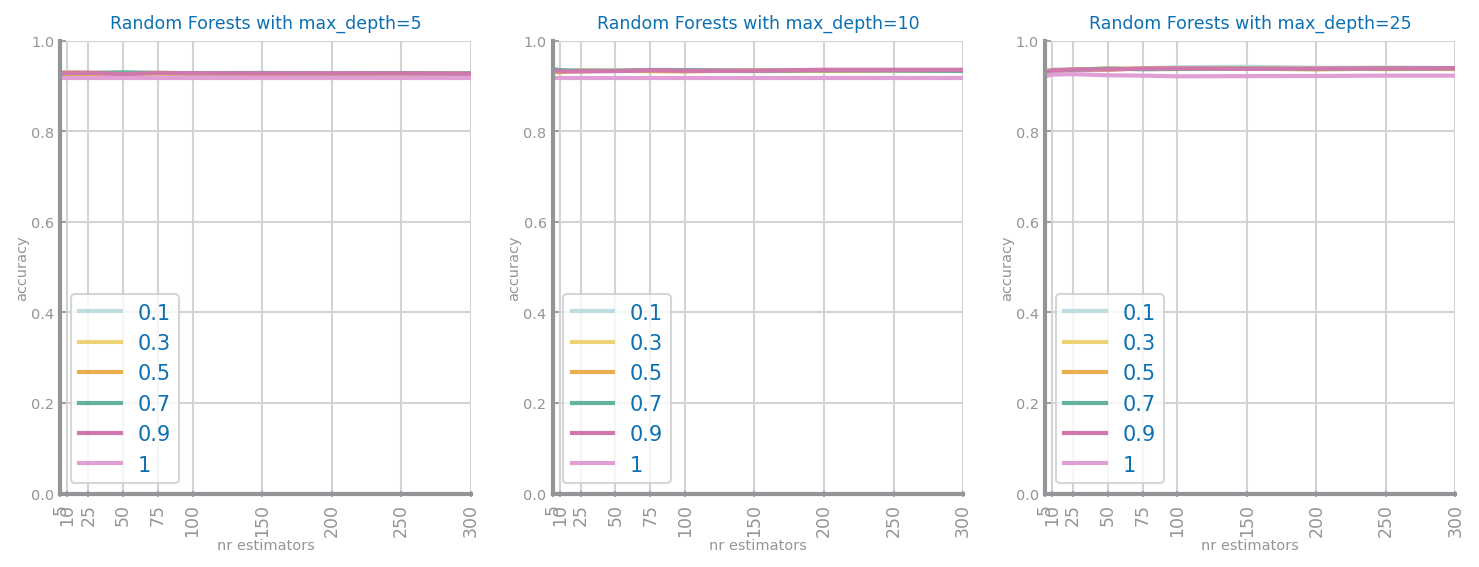

Best results with depth=25, 0.10 features and 150 estimators, with accuracy=0.94
Confusion Matrix Test
TruePositives:  2452
FalsePositives:  132
TrueNegatives:  90
FalseNegatives:  24


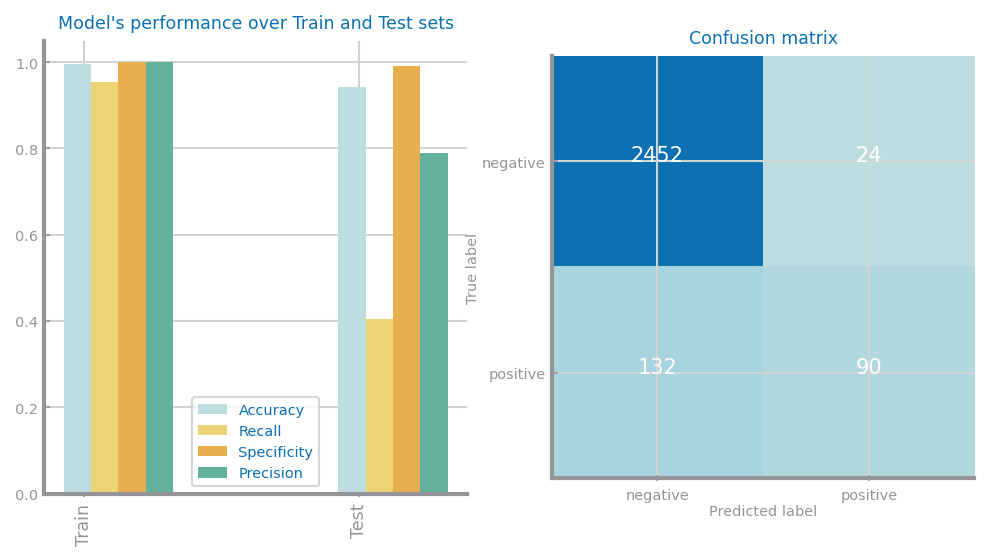

In [9]:
y: np.ndarray = data.pop(target).values
X: np.ndarray = data.values
    
labels = pd.unique(y)
print('{',len(X),',',len(y),'}')
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

n_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300]
max_depths = [5, 10, 25]
max_features = [.1, .3, .5, .7, .9, 1]
best = ('', 0, 0)
last_best = 0
best_tree = None

cols = len(max_depths)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    for f in max_features:
        yvalues = []
        for n in n_estimators:
            rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
            rf.fit(trnX, trnY)
            prdY = rf.predict(tstX)
            yvalues.append(metrics.accuracy_score(tstY, prdY))
            if yvalues[-1] > last_best:
                best = (d, f, n)
                last_best = yvalues[-1]
                best_tree = rf

        values[f] = yvalues
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Random Forests with max_depth=%d'%d,
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)

plt.show()
print('Best results with depth=%d, %1.2f features and %d estimators, with accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

prd_trn = best_tree.predict(trnX)
prd_tst = best_tree.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)

## Over Sampled Classification

{ 16502 , 16502 }
Confusion Matrix Test
TruePositives:  2475
FalsePositives:  102
TrueNegatives:  2374
FalseNegatives:  0


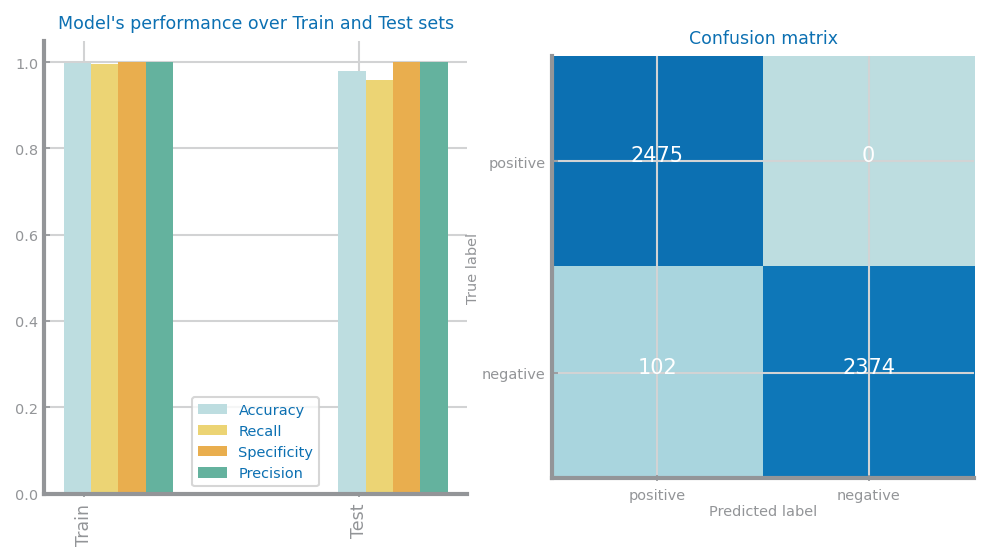

In [17]:
over_sampled = pd.concat([df_over,df_class_max])
y: np.ndarray = over_sampled.pop(target).values
X: np.ndarray = over_sampled.values
labels: np.ndarray = pd.unique(y)

print('{',len(X),',',len(y),'}')
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

rf = RandomForestClassifier(n_estimators=150, max_depth=25, max_features=0.1)
rf.fit(trnX, trnY)
prdY = rf.predict(tstX)

prd_trn = rf.predict(trnX)
prd_tst = rf.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)

## Under Sampled Classification

{ 1482 , 1482 }
Confusion Matrix Test
TruePositives:  182
FalsePositives:  43
TrueNegatives:  180
FalseNegatives:  40


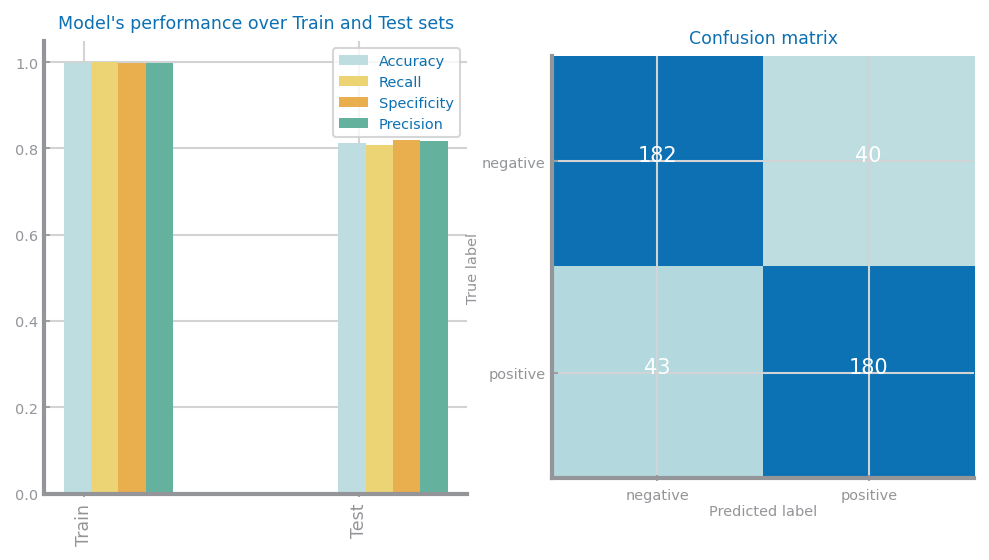

In [16]:
under_sampled = pd.concat([df_under,df_class_min])
y: np.ndarray = under_sampled.pop(target).values
X: np.ndarray = under_sampled.values
labels: np.ndarray = pd.unique(y)

print('{',len(X),',',len(y),'}')
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

rf = RandomForestClassifier(n_estimators=150, max_depth=25, max_features=0.1)
rf.fit(trnX, trnY)
prdY = rf.predict(tstX)

prd_trn = rf.predict(trnX)
prd_tst = rf.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)

## SMOTE Classification

{ 16502 , 16502 }
Confusion Matrix Test
TruePositives:  2343
FalsePositives:  58
TrueNegatives:  2417
FalseNegatives:  133


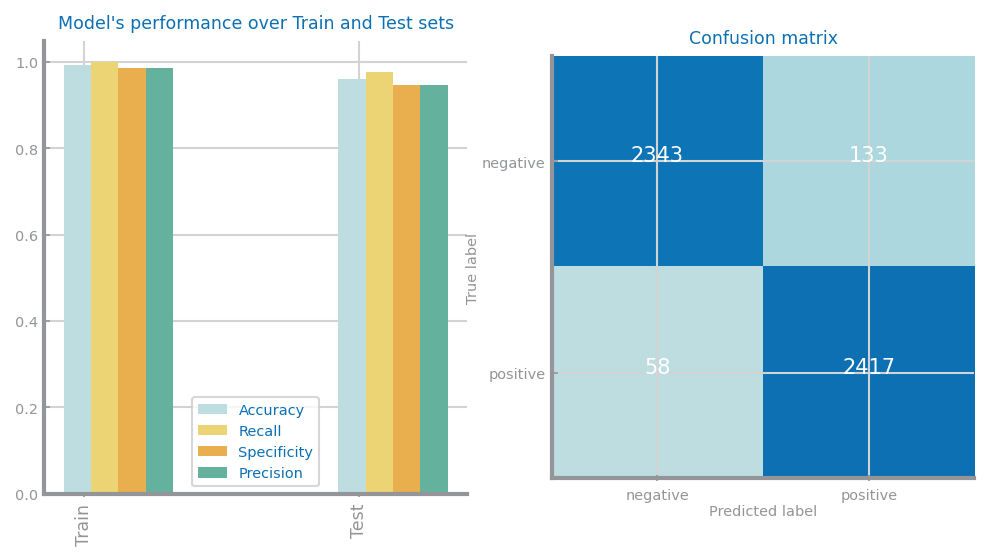

In [15]:
y = smote_y
X = smote_X
labels = pd.unique(y)
    
print('{',len(X),',',len(y),'}')
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

rf = RandomForestClassifier(n_estimators=150, max_depth=25, max_features=0.1)
rf.fit(trnX, trnY)
prdY = rf.predict(tstX)


prd_trn = rf.predict(trnX)
prd_tst = rf.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)